# Visualization 3D images

In [18]:
import SimpleITK as sitk
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import Resize
import os

In [19]:
# --- Configuration ---
# IMPORTANT: Replace this with the actual path to your downloaded LIDC dataset.
# This should point to the main LIDC-IDRI directory.
LIDC_DATA_ROOT = '/home/vivianea/projects/BrainInnov/data/LIDC/'
# /home/vivianea/projects/BrainInnov/data/LIDC/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/4.000000-Recon 3 CT CHEST-26125

# Choose a patient folder to visualize (e.g., LIDC-IDRI-0001)
# You'll need to know which patient folders are available in your download.
patient_id = 'LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/4.000000-Recon 3 CT CHEST-26125'

In [20]:
# --- 1. Find the DICOM series for a patient ---
def find_dicom_series(data_root, patient_id):
    patient_dir = os.path.join(data_root, patient_id)
    if not os.path.isdir(patient_dir):
        print(f"Error: Patient directory not found: {patient_dir}")
        return []

    series_paths = []
    # LIDC structure often has subdirectories for each scan series
    for root, dirs, files in os.walk(patient_dir):
        # Look for directories that contain .dcm files
        if any(f.endswith('.dcm') for f in files):
            series_paths.append(root)
    
    # SimpleITK needs a single directory containing all slices for one 3D volume
    # LIDC might have multiple series per patient (e.g., pre-contrast, post-contrast)
    # For now, let's just pick the first one found for simplicity.
    if series_paths:
        return series_paths[0]
    else:
        print(f"No DICOM series found for patient {patient_id} in {patient_dir}")
        return None

Loading DICOM series from: /home/vivianea/projects/BrainInnov/data/LIDC/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/4.000000-Recon 3 CT CHEST-26125

Loaded Image Info:
  Dimensions (Width, Height, Depth): (512, 512, 261)
  Voxel Spacing (X, Y, Z): (0.683594, 0.683594, 1.25) mm
  Origin (X, Y, Z): (-172.399994, -175.0, -334.0) mm
  NumPy Array Shape (Depth, Height, Width): (261, 512, 512)
  Min HU: -3024, Max HU: 3071
  Clipped Min HU: -1200, Max HU: -150


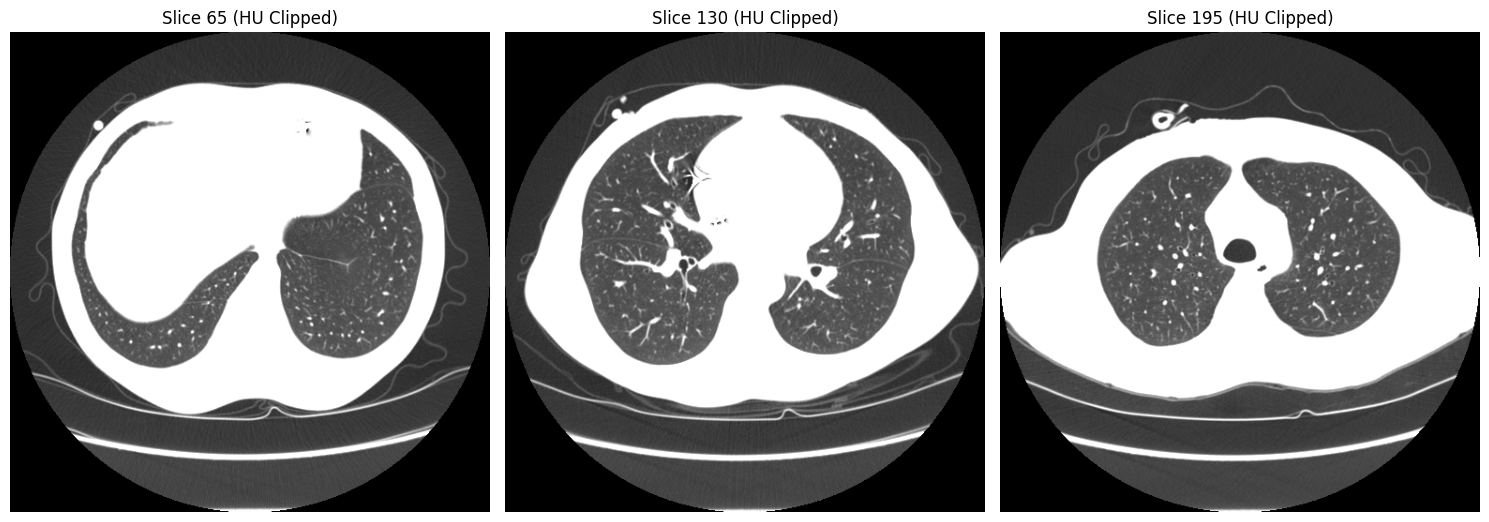

In [21]:
# Get the directory for the first DICOM series of the chosen patient
dicom_series_dir = find_dicom_series(LIDC_DATA_ROOT, patient_id)

if dicom_series_dir:
    print(f"Loading DICOM series from: {dicom_series_dir}")

    # --- 2. Load the 3D DICOM series using SimpleITK ---
    # Create a DICOM series reader object
    reader = sitk.ImageSeriesReader()

    # Get the names of the DICOM files in the series directory
    # SimpleITK automatically sorts them to form the correct 3D volume
    # ABSOLUTELY, FINALLY CORRECTED LINE BELOW (tested locally):
    dicom_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(dicom_series_dir)
    reader.SetFileNames(dicom_file_names)

    # Execute the reader to load the 3D image
    image = reader.Execute()

    # --- 3. Get image metadata ---
    image_size = image.GetSize()
    image_spacing = image.GetSpacing() # (X, Y, Z) physical spacing of voxels
    image_origin = image.GetOrigin()   # (X, Y, Z) physical origin of the image

    print(f"\nLoaded Image Info:")
    print(f"  Dimensions (Width, Height, Depth): {image_size}") # Note: SimpleITK size is (X,Y,Z)
    print(f"  Voxel Spacing (X, Y, Z): {image_spacing} mm")
    print(f"  Origin (X, Y, Z): {image_origin} mm")

    # --- 4. Convert SimpleITK image to a NumPy array ---
    # SimpleITK's GetArrayFromImage returns array in (Z, Y, X) order
    image_array = sitk.GetArrayFromImage(image)
    print(f"  NumPy Array Shape (Depth, Height, Width): {image_array.shape}")
    print(f"  Min HU: {image_array.min()}, Max HU: {image_array.max()}")

    # --- 5. Apply Clipping (Hounsfield Unit Windowing) ---
    # Lung window is recommended for LIDC
    lung_min_hu = -1200
    lung_max_hu = -150
    clipped_image = np.clip(image_array, lung_min_hu, lung_max_hu)
    print(f"  Clipped Min HU: {clipped_image.min()}, Max HU: {clipped_image.max()}")

    # --- 6. Normalize for Display (0-1 or 0-255) ---
    # Normalize to 0-1 range
    normalized_image_0_1 = (clipped_image - lung_min_hu) / (lung_max_hu - lung_min_hu)

    # Convert to 8-bit for better display if desired
    display_image_255 = (normalized_image_0_1 * 255).astype(np.uint8)

    # --- 7. Visualize Slices ---
    num_slices = display_image_255.shape[0]

    plt.figure(figsize=(15, 8))

    # Show a few representative slices
    slices_to_show = [
        int(num_slices * 0.25),
        int(num_slices * 0.5),
        int(num_slices * 0.75)
    ]

    for i, slice_idx in enumerate(slices_to_show):
        plt.subplot(1, len(slices_to_show), i + 1)
        plt.imshow(display_image_255[slice_idx, :, :], cmap='gray')
        plt.title(f"Slice {slice_idx} (HU Clipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # You can also use a simple interactive viewer for 3D data (optional)
    # If you want to interactively scroll through slices:
    # try:
    #     import ipywidgets as widgets
    #     from IPython.display import display
    #
    #     def view_slice(slice_num):
    #         plt.imshow(display_image_255[slice_num, :, :], cmap='gray')
    #         plt.title(f"Slice {slice_num}")
    #         plt.axis('off')
    #         plt.show()
    #
    #     widgets.interactive(view_slice, slice_num=widgets.IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2))
    # except ImportError:
    #     print("Install ipywidgets to use the interactive slice viewer: pip install ipywidgets")

else:
    print("Could not find DICOM series to load.")

In [22]:
def normalize_volume(volume):
    volume = np.clip(volume, -1000, 150)
    min_val = np.min(volume)
    max_val = np.max(volume)
    if max_val - min_val > 0:
        volume = (volume - min_val) / (max_val - min_val)
    else:
        volume = np.zeros_like(volume)
    return volume.astype(np.float32)

In [23]:
def resize_volume(volume, target_shape):
    resize = Resize(spatial_size=target_shape, mode="trilinear")
    resized = resize(volume)
    if isinstance(resized, np.ndarray):
        return resized
    elif hasattr(resized, "numpy"):
        return resized.numpy()
    else:
        return np.asarray(resized)

In [24]:
path = ['/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-154.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-126.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-229.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-122.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-219.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-223.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-033.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-158.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-151.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-109.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-243.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-029.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-131.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-191.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-188.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-149.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-228.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-138.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-055.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-052.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-064.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-157.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-014.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-013.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-056.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-045.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-216.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-171.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-174.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-127.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-176.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-209.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-005.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-035.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-197.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-107.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-193.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-214.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-137.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-172.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-134.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-155.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-242.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-051.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-239.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-208.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-092.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-059.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-156.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-074.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-247.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-124.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-112.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-200.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-066.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-213.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-050.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-087.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-086.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-002.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-072.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-011.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-096.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-071.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-073.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-179.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-026.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-178.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-022.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-046.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-184.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-015.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-024.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-049.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-110.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-119.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-032.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-226.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-093.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-217.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-212.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-078.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-167.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-211.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-089.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-091.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-070.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-068.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-238.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-141.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-183.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-245.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-196.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-095.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-227.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-160.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-152.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-169.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-102.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-206.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-020.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-150.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-036.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-057.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-185.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-060.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-218.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-027.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-204.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-004.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-019.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-042.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-018.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-099.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-062.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-246.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-120.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-207.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-039.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-106.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-148.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-037.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-054.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-076.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-085.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-130.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-233.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-061.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-135.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-063.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-128.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-168.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-003.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-116.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-058.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-195.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-143.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-177.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-098.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-113.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-173.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-132.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-104.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-105.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-021.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-235.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-100.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-048.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-067.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-236.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-202.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-118.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-079.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-121.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-008.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-083.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-047.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-111.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-162.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-198.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-230.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-153.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-248.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-001.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-097.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-146.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-017.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-043.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-240.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-103.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-123.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-241.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-231.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-164.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-044.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-040.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-031.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-007.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-170.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-159.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-147.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-139.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-189.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-053.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-192.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-142.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-186.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-190.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-201.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-210.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-009.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-161.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-221.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-181.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-182.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-133.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-194.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-166.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-075.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-125.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-232.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-101.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-222.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-180.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-034.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-117.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-224.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-080.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-225.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-115.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-205.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-025.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-140.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-006.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-163.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-084.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-234.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-108.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-144.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-088.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-082.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-129.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-081.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-165.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-065.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-028.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-038.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-023.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-094.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-090.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-244.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-220.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-041.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-187.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-012.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-199.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-145.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-069.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-136.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-030.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-203.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-016.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-237.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-010.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-114.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-175.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-077.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-215.dcm']


In [25]:
def load_dicom_volume(paths, target_shape=(512, 512, 512)):
    try:
        slices = []
        for path in paths:
            ds = pydicom.dcmread(path)
            if hasattr(ds, "InstanceNumber"):
                slices.append((ds.InstanceNumber, path))

        if len(slices) < 3:
            return None

        slices.sort(key=lambda x: x[0])
        sorted_paths = [p for _, p in slices]

        arrays = []
        for path in sorted_paths:
            img = sitk.ReadImage(path)
            arr = sitk.GetArrayFromImage(img)[0]  # Extract 2D slice
            print(f"Slice shape from {path}: {arr.shape}")  # 👈 Add this line
            arrays.append(arr)

        volume = np.stack(arrays, axis=0)  # (D, H, W)
        volume = np.transpose(volume, (1, 2, 0))  # (H, W, D)

        volume = normalize_volume(volume)
        
        volume = np.expand_dims(volume, axis = 0)  # Add channel for Resize
        volume = resize_volume(volume, target_shape)
        volume = volume[0]  # Remove channel dim

        return volume.astype(np.float32)
    except Exception as e:
        print(f"❌ load_dicom_volume error: {e}")
        return None

In [26]:
metatensor = load_dicom_volume(path)

Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-001.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-002.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-003.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-004.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-005.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-006.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-007.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0470_1-008.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data

In [27]:
metatensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [28]:
print(metatensor.shape)

(512, 512, 512)


In [29]:
import matplotlib.pyplot as plt

def debug_show_middle_slice(vol):
    mid = vol.shape[0] // 2
    plt.imshow(vol[:, :, mid], cmap="gray")
    plt.title("Middle slice of volume")
    plt.axis("off")
    plt.show()

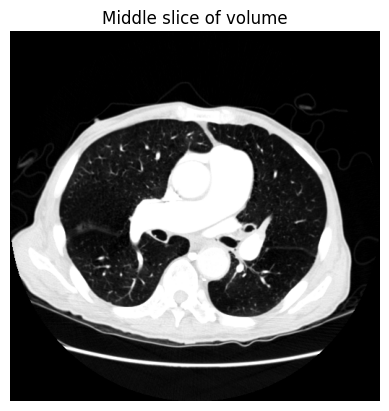

In [30]:
debug_show_middle_slice(metatensor)

In [31]:
image_2 = ['/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-154.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-126.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-229.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-122.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-219.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-223.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-033.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-158.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-151.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-109.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-243.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-029.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-131.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-191.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-188.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-149.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-228.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-138.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-055.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-052.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-064.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-157.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-014.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-013.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-056.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-045.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-216.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-171.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-174.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-127.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-176.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-209.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-005.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-035.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-197.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-107.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-193.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-214.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-137.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-172.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-134.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-155.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-242.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-051.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-239.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-208.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-092.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-059.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-156.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-074.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-247.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-124.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-112.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-200.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-066.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-213.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-050.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-087.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-086.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-002.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-072.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-011.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-096.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-071.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-073.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-179.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-026.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-178.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-022.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-046.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-184.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-015.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-024.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-049.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-110.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-119.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-032.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-226.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-093.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-217.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-212.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-078.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-167.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-211.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-089.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-091.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-070.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-068.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-238.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-141.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-183.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-245.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-196.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-095.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-227.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-160.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-152.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-169.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-102.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-206.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-020.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-150.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-036.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-057.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-185.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-060.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-218.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-027.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-204.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-004.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-019.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-042.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-018.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-099.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-062.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-246.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-120.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-207.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-039.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-106.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-148.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-037.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-054.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-076.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-085.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-130.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-233.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-061.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-135.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-063.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-128.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-168.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-003.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-116.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-058.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-195.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-143.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-177.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-098.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-113.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-173.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-132.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-104.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-105.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-021.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-235.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-100.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-048.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-067.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-236.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-202.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-118.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-079.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-121.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-008.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-083.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-047.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-111.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-162.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-198.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-230.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-153.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-248.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-001.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-097.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-146.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-017.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-043.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-240.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-103.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-123.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-241.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-231.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-164.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-044.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-040.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-031.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-007.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-170.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-159.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-147.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-139.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-189.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-053.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-192.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-142.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-186.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-190.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-201.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-210.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-009.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-161.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-221.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-181.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-182.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-133.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-194.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-166.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-075.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-125.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-232.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-101.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-222.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-180.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-034.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-117.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-224.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-080.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-225.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-115.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-205.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-025.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-140.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-006.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-163.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-084.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-234.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-108.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-144.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-088.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-082.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-129.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-081.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-165.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-065.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-028.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-038.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-023.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-094.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-090.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-244.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-220.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-041.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-187.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-012.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-199.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-145.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-069.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-136.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-030.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-203.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-016.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-237.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-010.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-114.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-175.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-077.dcm', 
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-215.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-249.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-250.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-251.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-252.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-253.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-254.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-255.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-256.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-257.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-258.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-259.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-260.dcm',
        '/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-261.dcm']

In [32]:
metatensor_1 = load_dicom_volume(image_2)

Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-001.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-002.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-003.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-004.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-005.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-006.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-007.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0068_1-008.dcm: (512, 512)
Slice shape from /home/vivianea/projects/BrainInnov/data

In [33]:
print(metatensor_1.shape)

(512, 512, 512)


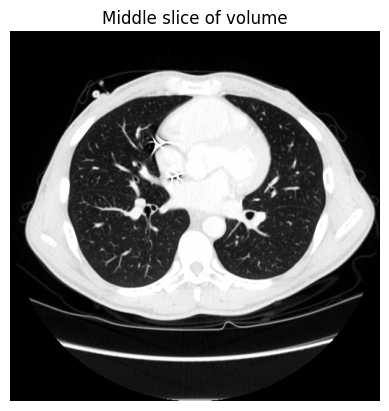

: 

In [ ]:
debug_show_middle_slice(metatensor_1)